In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install dm-sonnet tqdm
# !pip install scprep

In [3]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde


import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

from sklearn.preprocessing import StandardScaler

In [4]:
# seed = 42
# np.random.seed(42)
# tf.random.set_seed(seed)

In [5]:
class SCData(object):
    """ Base Class for single cell like trajectory data """

    def __init__(
        self, embedding_name="phate", max_dim=None, use_velocity=True, version=5
    ):
        super().__init__()
        self.embedding_name = embedding_name
        self.use_velocity = use_velocity
        if version == 5:
            data_file = "./eb_velocity_v5.npz"
        else:
            raise ValueError("Unknown Version number")
        self.load(data_file, max_dim)
        self.val_labels = []

    def has_validation_samples(self):
        return False

    def load(self, data_file, max_dim):
        self.data_dict = np.load(data_file, allow_pickle=True)
        self.labels = self.data_dict["sample_labels"]
        if self.embedding_name not in self.data_dict.keys():
            raise ValueError("Unknown embedding name %s" % self.embedding_name)
        embedding = self.data_dict[self.embedding_name]
        scaler = StandardScaler()
        scaler.fit(embedding)
        self.ncells = embedding.shape[0]
        assert self.labels.shape[0] == self.ncells
        # Scale so that embedding is normally distributed
        self.data = scaler.transform(embedding)

        if self.has_velocity() and self.use_velocity:
            if self.embedding_name == "pcs":
                delta = self.data_dict["pcs_delta"]
            elif self.embedding_name == "phate":
                delta = self.data_dict["delta_embedding"]
            else:
                raise NotImplementedError("rna velocity must use phate")
            assert delta.shape[0] == self.ncells
            # Ignore mean from embedding
            self.velocity = delta / scaler.scale_

        if max_dim is not None and self.data.shape[1] > max_dim:
            print("Warning: Clipping dimensionality to %d" % max_dim)
            self.data = self.data[:, :max_dim]
            if self.has_velocity() and self.use_velocity:
                self.velocity = self.velocity[:, :max_dim]

    def get_times(self):
        return self.labels
    
    def get_unique_times(self):
        return np.unique(self.labels)

    def get_data(self):
        return self.data

    def get_velocity(self):
        return self.velocity
    
    def get_shape(self):
        return [self.data.shape[1]]
    
    def get_ncells(self):
        return self.ncells

    def has_velocity(self):
        return True

    def leaveout_timepoint(self, tp):
        """ Takes a timepoint label to leaveout
        Alters data stored in object to leave out all data associated
        with that timepoint.
        """
        if tp < 0:
            raise RuntimeError("Cannot leaveout negative timepoint %d." % tp)
        mask = self.labels != tp
        print("Leaving out %d samples from sample %d" % (np.sum(~mask), tp))
        self.labels = self.labels[mask]
        self.data = self.data[mask]
        self.velocity = self.velocity[mask]
        self.ncells = np.sum(mask)

    def sample_index(self, n, label_subset):
        arr = np.arange(self.ncells)[self.labels == label_subset]
        return np.random.choice(arr, size=n)

    def known_base_density(self):
        """ Returns if the dataset starts from a known base density.
        Generally single cell datasets do not have a known base density
        where generated datasets do.
        """
        return False

    def base_density(self):
        import math
        def standard_normal_logprob(z):
            logZ = -0.5 * math.log(2 * math.pi)
            return tf.math.reduce_sum(logZ - (z**2) / 2, axis=1, keepdims=True)

        return standard_normal_logprob

    def base_sample(self):
        return tf.random.normal

    def plot_density(self):
        import matplotlib.pyplot as plt

        npts = 100
        side = np.linspace(-4, 4, npts)
        xx, yy = np.meshgrid(side, side)
        xx = tf.convert_to_tensor(xx, dtype=tf.float32)
        yy = tf.convert_to_tensor(yy, dtype=tf.float32)
        z_grid = tf.concat([tf.reshape(xx, (-1, 1)), tf.reshape(yy, (-1,1))], 1)
        logp_grid = self.base_density()(z_grid)
        plt.pcolormesh(xx, yy, np.exp(logp_grid.numpy()).reshape(npts, npts))
        plt.show()

    def plot_data(self):
        import scprep
        import matplotlib.pyplot as plt

        nbase = 5000
        all_data = np.concatenate(
            [self.get_data()],
            axis=0,
        )
        lbs = np.concatenate([self.get_times()])
        if all_data.shape[1] == 2:
            scprep.plot.scatter2d(all_data, c=lbs)
        else:
            fig, axes = plt.subplots(2, all_data.shape[1] // 2)
            axes = axes.flatten()
            for i in range(all_data.shape[1] - 1):
                scprep.plot.scatter2d(
                    all_data[:, i : i + 2],
                    c=lbs,
                    ax=axes[i],
                    xlabel="PC %d" % (i + 1),
                    ylabel="PC %d" % (i + 2),
                )
        plt.show()

    def plot_velocity(self):
        import matplotlib.pyplot as plt

        idx = np.random.randint(self.get_ncells(), size=200)
        data = self.get_data()[idx]
        velocity = self.velocity[idx]
        plt.quiver(data[:, 0], data[:, 1], velocity[:, 0], velocity[:, 1])
        plt.show()

    def plot_paths(self):
        paths = self.get_paths()
        paths = paths[:1000]
        import matplotlib.pyplot as plt

        for path in paths:
            plt.plot(path[:, 0], path[:, 1])
        plt.show()


In [6]:
ebdata = SCData()

In [7]:
timepoints = ebdata.get_unique_times()

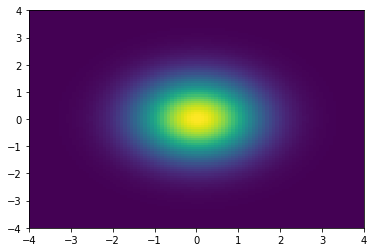

In [8]:
ebdata.plot_density()

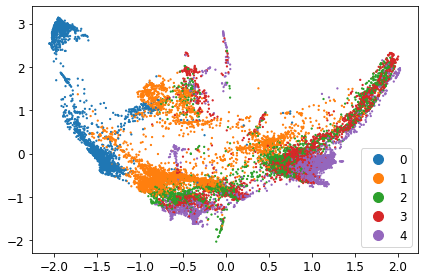

In [9]:
ebdata.plot_data()

In [10]:
# Use maximum timepoint to establish integration_times as some timepoints may be left out for validation etc.
time_scale = 0.5
int_tps = (np.arange(max(timepoints) + 1) + 1.0) * time_scale

In [11]:
int_tps

array([0.5, 1. , 1.5, 2. , 2.5])

In [12]:
tfb = tfp.bijectors
tfd = tfp.distributions

# Model

In [13]:
# Creating the ODEfunc
# state_time_derivative_fn: `Callable(time, state)` -> state_time_derivative
# e.g. Neural network with inputs and outputs of the same shapes and dtypes.

class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
#     print("t = ", t)
#     print("inpts = ", inputs)
    return self._model(inputs)

In [14]:
LR = 0.001 
NUM_EPOCHS = 50  
STACKED_FFJORDS = 1
NUM_HIDDEN = 64  
NUM_LAYERS = 4  
NUM_OUTPUT = 2
BATCH_SIZE = 1000 #200

In [15]:
# # Creating the ODE Solver
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson

# bijectors = []
# for _ in range(STACKED_FFJORDS):
#   mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
#   next_ffjord = tfb.FFJORD(
#       state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
#       trace_augmentation_fn=trace_augmentation_fn, initial_time=4.0, final_time=[5.0,6.0])
#   bijectors.append(next_ffjord)

# stacked_ffjord = tfb.Chain(bijectors[::-1])

In [16]:
mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)

def get_ffjord_model(initial_time=0.0, final_time=0.5):
    bijectors = []
    for _ in range(STACKED_FFJORDS):
      next_ffjord = tfb.FFJORD(
          state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
          trace_augmentation_fn=trace_augmentation_fn, initial_time=initial_time, final_time=final_time)
      bijectors.append(next_ffjord)
    
    return tfb.Chain(bijectors[::-1])

In [17]:
stacked_ffjord_0 = get_ffjord_model(initial_time=0.0, final_time=1.0)
stacked_ffjord_1 = get_ffjord_model(initial_time=1.0, final_time=2.0)
stacked_ffjord_2 = get_ffjord_model(initial_time=2.0, final_time=3.0)
stacked_ffjord_3 = get_ffjord_model(initial_time=3.0, final_time=4.0)
stacked_ffjord_4 = get_ffjord_model(initial_time=4.0, final_time=5.0)

In [19]:
# TransformedDistribution which is the result of warping base_distribution with stacked_ffjord bijector
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([1.0, 1.0]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)


transformed_distribution_0 = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord_0)
transformed_distribution_1 = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord_1)
transformed_distribution_2 = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord_2)
transformed_distribution_3 = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord_3)
transformed_distribution_4 = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord_4)

In [20]:
len_0 = len(np.arange(ebdata.get_ncells())[ebdata.get_times() == 0])
len_1 = len(np.arange(ebdata.get_ncells())[ebdata.get_times() == 1])
len_2 = len(np.arange(ebdata.get_ncells())[ebdata.get_times() == 2])
len_3 = len(np.arange(ebdata.get_ncells())[ebdata.get_times() == 3])
len_4 = len(np.arange(ebdata.get_ncells())[ebdata.get_times() == 4])
print(len_0, len_1, len_2, len_3, len_4)

2381 4163 3278 3665 3332


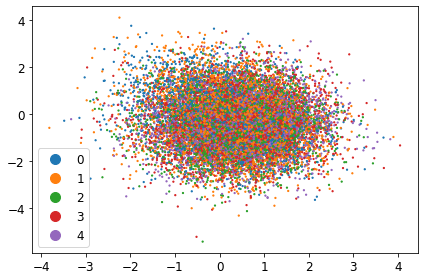

In [21]:
import scprep
import matplotlib.pyplot as plt

nbase = 5000
all_data = np.concatenate(
    [transformed_distribution_0.sample(len_0), transformed_distribution_1.sample(len_1), transformed_distribution_2.sample(len_2), transformed_distribution_3.sample(len_3), transformed_distribution_4.sample(len_4)],
    axis=0,
)
lbs = np.concatenate([ebdata.get_times()])
if all_data.shape[1] == 2:
    scprep.plot.scatter2d(all_data, c=lbs)
else:
    fig, axes = plt.subplots(2, all_data.shape[1] // 2)
    axes = axes.flatten()
    for i in range(all_data.shape[1] - 1):
        scprep.plot.scatter2d(
            all_data[:, i : i + 2],
            c=lbs,
            ax=axes[i],
            xlabel="PC %d" % (i + 1),
            ylabel="PC %d" % (i + 2),
        )
plt.show()

In [22]:
def get_direction_regularization_fn(diffeq, itp=0.5, tp=0, vecint=0.0001):
    similarity_loss = 0
    itp = tf.convert_to_tensor(itp, dtype=tf.float32)
    idx = ebdata.sample_index(BATCH_SIZE, tp)
    x = ebdata.get_data()[idx]
    v = ebdata.get_velocity()[idx]
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    v = tf.convert_to_tensor(v, dtype=tf.float32)
    x += tf.random.normal(tf.shape(x)) * 0.1
    # Only penalizes at the time / place of visible samples
    direction = diffeq.forward(x)
    similarity_loss -= tf.reduce_mean(tf.keras.losses.cosine_similarity(direction, v))
    return similarity_loss * vecint

In [23]:
def model_forward(diffeq, transformed_distribution, target_sample):
  return diffeq.forward(target_sample), transformed_distribution.log_prob(target_sample)

In [26]:
@tf.function
def train_step(optimizer, target_sample_0, target_sample_1, target_sample_2, target_sample_3, target_sample_4, dir_reg=False):
  with tf.GradientTape() as tape:
    
    z0, loss_0 = model_forward(stacked_ffjord_1, transformed_distribution_0, target_sample_0)
    loss_total = -tf.reduce_mean(loss_0)

    target_sample_1 = tf.concat([z0, target_sample_1], 0)

    z1, loss_1 = model_forward(stacked_ffjord_2, transformed_distribution_1, target_sample_1)
    loss_total += (-tf.reduce_mean(loss_1))

    target_sample_2 = tf.concat([z1, target_sample_2], 0)

    z2, loss_2 = model_forward(stacked_ffjord_3, transformed_distribution_2, target_sample_2)
    loss_total += (-tf.reduce_mean(loss_2))

    target_sample_3 = tf.concat([z2, target_sample_3], 0)

    z3, loss_3 = model_forward(stacked_ffjord_4, transformed_distribution_3, target_sample_3)
    loss_total += (-tf.reduce_mean(loss_3))

    target_sample_4 = tf.concat([z3, target_sample_4], 0)

    _, loss_4 = model_forward(stacked_ffjord_4, transformed_distribution_4, target_sample_4)
    loss_total += (-tf.reduce_mean(loss_4))

    if dir_reg:
      loss_total += get_direction_regularization_fn(stacked_ffjord_0, itp=0.5, tp=0, vecint=dir_coeff)
      loss_total += get_direction_regularization_fn(stacked_ffjord_1, itp=0.5, tp=1, vecint=dir_coeff)
      loss_total += get_direction_regularization_fn(stacked_ffjord_2, itp=0.5, tp=2, vecint=dir_coeff)
      loss_total += get_direction_regularization_fn(stacked_ffjord_3, itp=0.5, tp=3, vecint=dir_coeff)
      loss_total += get_direction_regularization_fn(stacked_ffjord_4, itp=0.5, tp=4, vecint=dir_coeff)
    
    # if energy_reg:
    #   loss_total += get_direction_regularization_fn(stacked_ffjord_4, itp=0.5, tp=4, vecint=dir_coeff)
  variables = tape.watched_variables()
  gradients = tape.gradient(loss_total, variables)
  optimizer.apply(gradients, variables)


In [27]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(4000):
    
    # load data and add noise
    idx_0 = ebdata.sample_index(BATCH_SIZE, 0)
    idx_1 = ebdata.sample_index(BATCH_SIZE, 1)
    idx_2 = ebdata.sample_index(BATCH_SIZE, 2)
    idx_3 = ebdata.sample_index(BATCH_SIZE, 3)
    idx_4 = ebdata.sample_index(BATCH_SIZE, 4)
    
    batch_0 = ebdata.get_data()[idx_0]
    batch_1 = ebdata.get_data()[idx_1]
    batch_2 = ebdata.get_data()[idx_2]
    batch_3 = ebdata.get_data()[idx_3]
    batch_4 = ebdata.get_data()[idx_4]
    #if args.training_noise > 0.0:
        #x += np.random.randn(*x.shape) * args.training_noise
    batch_0 = tf.convert_to_tensor(batch_0, dtype=tf.float32)
    batch_1 = tf.convert_to_tensor(batch_1, dtype=tf.float32)
    batch_2 = tf.convert_to_tensor(batch_2, dtype=tf.float32)
    batch_3 = tf.convert_to_tensor(batch_3, dtype=tf.float32)
    batch_4 = tf.convert_to_tensor(batch_4, dtype=tf.float32)
    
    train_step(optimizer, batch_0, batch_1, batch_2, batch_3, batch_4)

  0%|          | 0/4000 [00:00<?, ?it/s]W0619 01:21:00.444749 4415229376 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  3%|▎         | 129/4000 [20:08<10:04:11,  9.36s/it]


KeyboardInterrupt: 

In [ ]:
nbase = 5000
all_data = np.concatenate(
    [transformed_distribution_0.sample(len_0), transformed_distribution_1.sample(len_1), transformed_distribution_2.sample(len_2), transformed_distribution_3.sample(len_3), transformed_distribution_4.sample(len_4)],
    axis=0,
)
lbs = np.concatenate([ebdata.get_times()])
if all_data.shape[1] == 2:
    scprep.plot.scatter2d(all_data, c=lbs)
else:
    fig, axes = plt.subplots(2, all_data.shape[1] // 2)
    axes = axes.flatten()
    for i in range(all_data.shape[1] - 1):
        scprep.plot.scatter2d(
            all_data[:, i : i + 2],
            c=lbs,
            ax=axes[i],
            xlabel="PC %d" % (i + 1),
            ylabel="PC %d" % (i + 2),
        )
plt.show()